In [1]:
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [3]:
sp_filename = "000000000009"
sp_path = "train_pts/{}_points.json".format(sp_filename)
image = cv2.imread('train2017/{}.jpg'.format(sp_filename))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

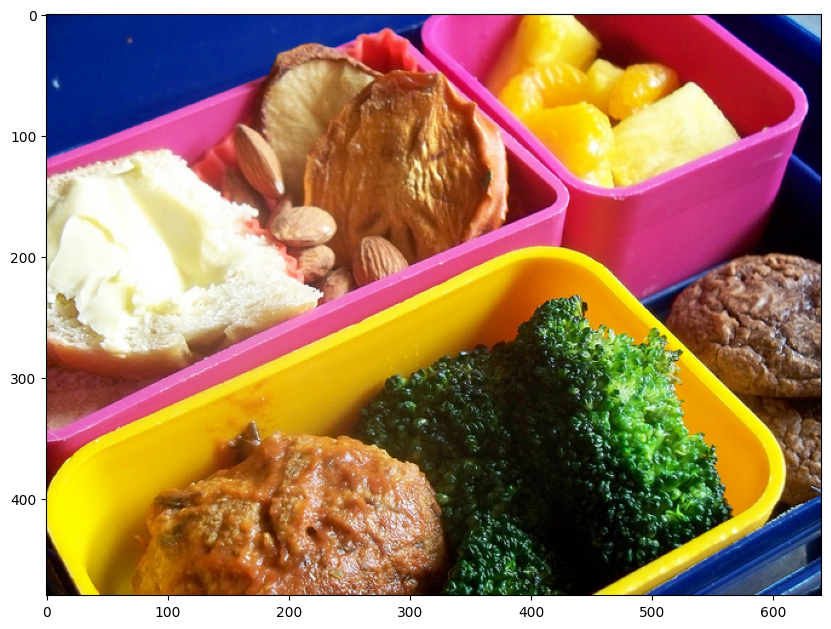

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [5]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "segment-anything/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [6]:
predictor.set_image(image)

In [14]:
with open(sp_path, 'r') as input_file:
  whole_input = json.load(input_file)

print(whole_input)

input_points = []
point_classes = []
for pts in whole_input:
  individual_pts = pts['seg_point']
  class_of_point = pts['label']
  input_points.append(individual_pts)
  point_classes.append(class_of_point)
  
print(point_classes)
points_n_idx = zip(reversed(input_points), reversed(point_classes))
print(points_n_idx)
one_point = np.array([input_points[0]])

set_of_classes = list(set(point_classes))
print(set_of_classes)

[{'image_id': 9, 'category_id': 55, 'label': 'orange', 'seg_point': [496, 62]}, {'image_id': 9, 'category_id': 55, 'label': 'orange', 'seg_point': [414, 63]}, {'image_id': 9, 'category_id': 55, 'label': 'orange', 'seg_point': [413, 36]}, {'image_id': 9, 'category_id': 55, 'label': 'orange', 'seg_point': [440, 111]}, {'image_id': 9, 'category_id': 51, 'label': 'bowl', 'seg_point': [118, 93]}, {'image_id': 9, 'category_id': 51, 'label': 'bowl', 'seg_point': [298, 220]}, {'image_id': 9, 'category_id': 51, 'label': 'bowl', 'seg_point': [544, 120]}, {'image_id': 9, 'category_id': 56, 'label': 'broccoli', 'seg_point': [408, 355]}, {'image_id': 9, 'category_id': 51, 'label': 'bowl', 'seg_point': [169, 334]}]
['orange', 'orange', 'orange', 'orange', 'bowl', 'bowl', 'bowl', 'broccoli', 'bowl']
['orange', 'broccoli', 'bowl']


[[496  62]]
[1]
[[496, 62], [414, 63], [413, 36], [440, 111], [118, 93], [298, 220], [544, 120], [408, 355], [169, 334]]


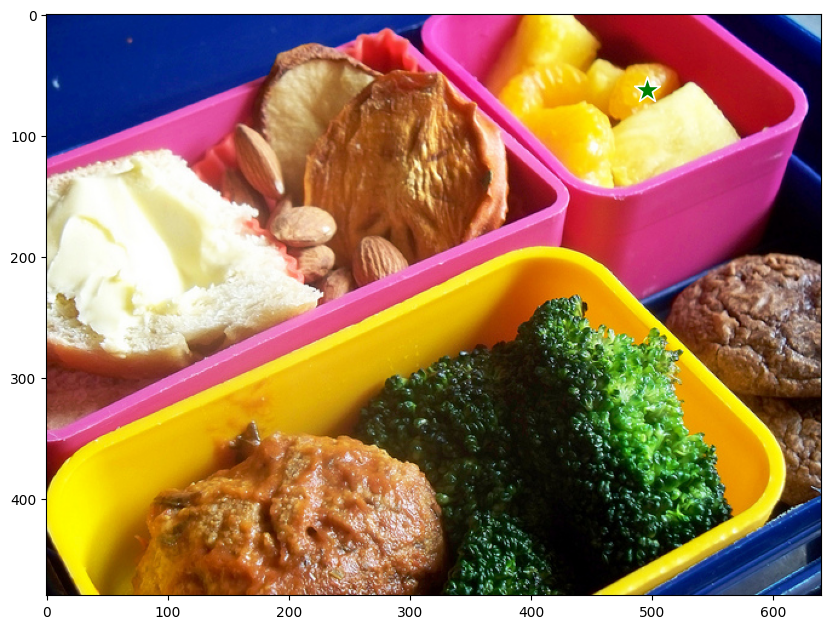

In [15]:
plt.figure(figsize=(10,10))
input_label = np.array([1])
one_point = np.array([input_points[0]])
print(one_point)
print(input_label)
print(input_points)
plt.imshow(image)


show_points(one_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [16]:
semantic_mask = []

for pt, cls in points_n_idx:
    print(pt, cls)
    print(set_of_classes)
    p_pt = np.array([pt])
    # print(p_pt)
    masks, scores, logits = predictor.predict(
        point_coords=p_pt,
        point_labels=np.array([1]),
        multimask_output=True,
    )

    best_score_idx = np.where(scores == max(scores))[0][0]
    # print(best_score_idx)
    class_val = set_of_classes.index(cls)
    print(class_val)
    best_mask = masks[best_score_idx].astype(int)
    semantic_mask.append(best_mask)
    break

print(semantic_mask)

[169, 334] bowl
['orange', 'broccoli', 'bowl']
2
[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])]


1
1
[[496, 62], [414, 63], [413, 36], [440, 111], [118, 93], [298, 220], [544, 120], [408, 355], [169, 334]]


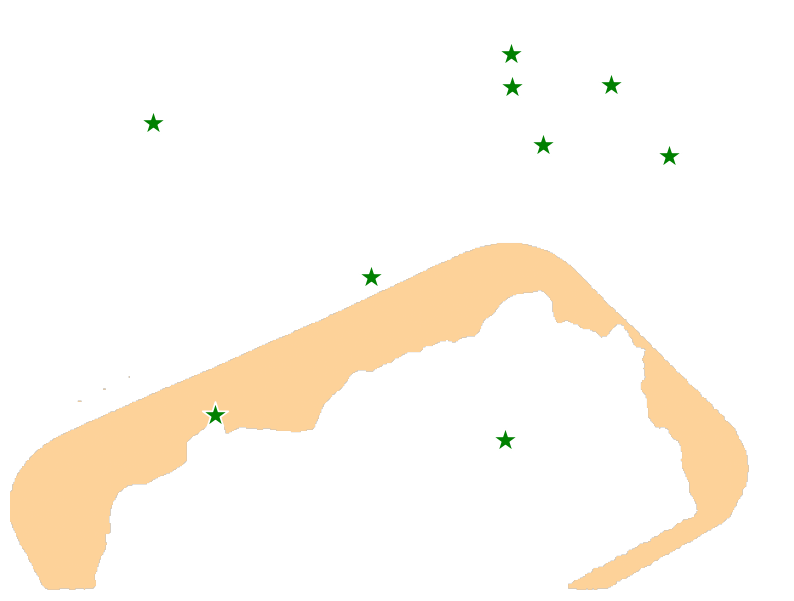

In [18]:
best_score_idx = np.where(scores == max(scores))[0][0]
print(best_score_idx)

print(len(semantic_mask))

plt.figure(figsize=(10,10))
# plt.imshow(image)
for m in semantic_mask:
  show_mask(m, plt.gca(), random_color=True)
print(input_points)
show_points(np.array(input_points), np.ones(len(input_points)), plt.gca())
plt.axis('off')
plt.show()  
  

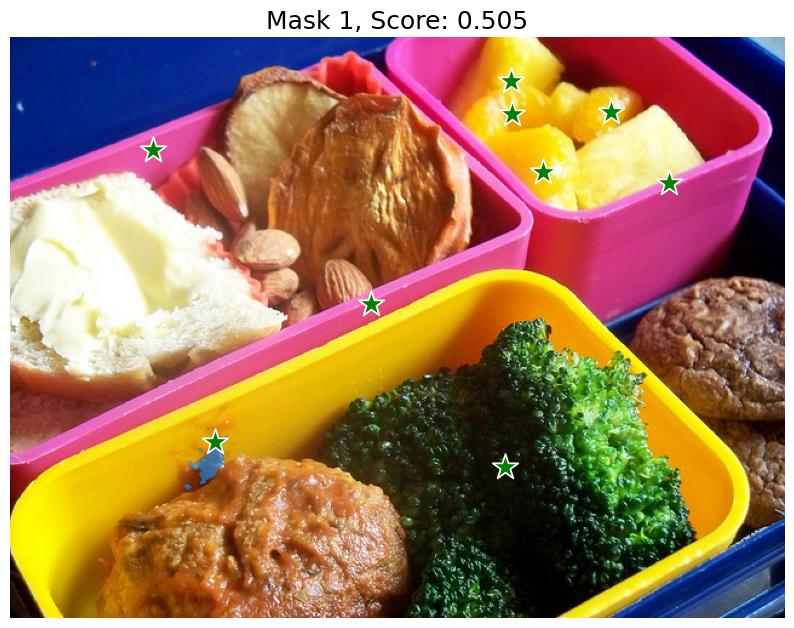

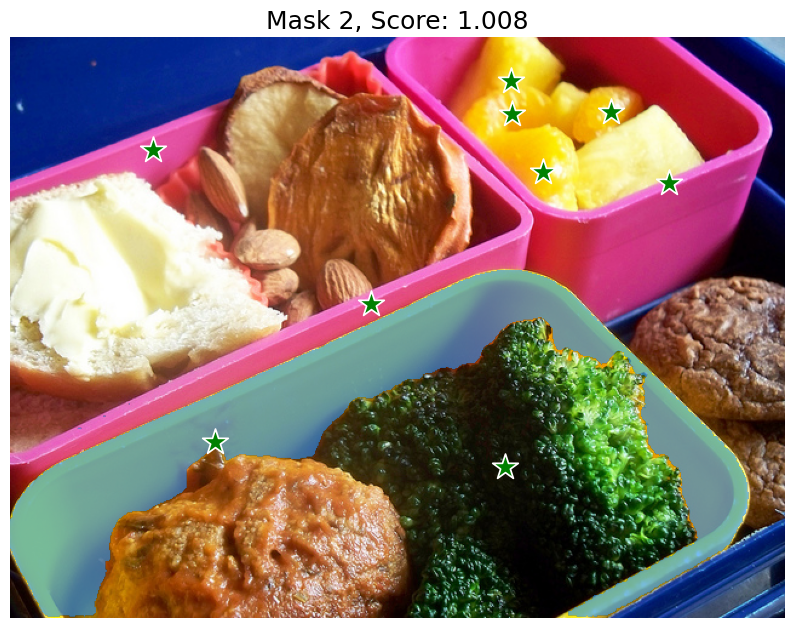

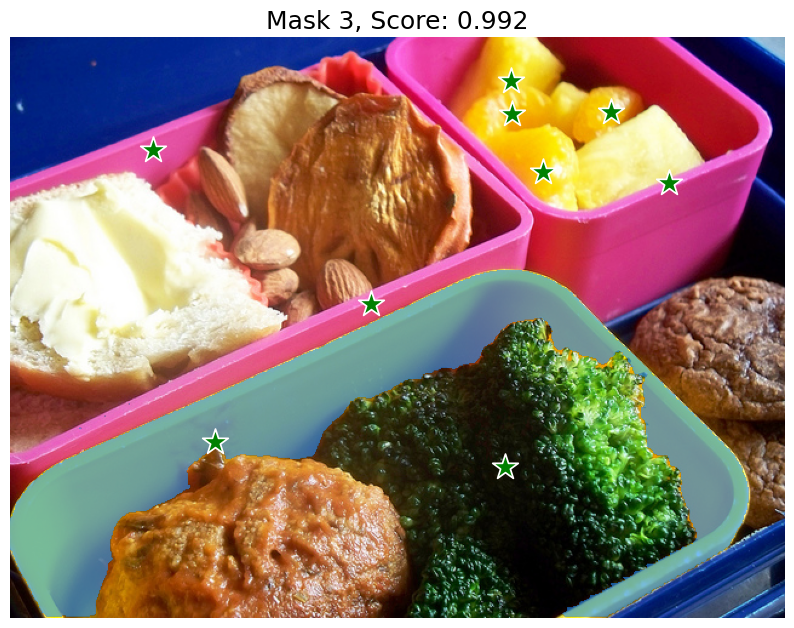

In [11]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(np.array(input_points), np.ones(len(input_points)), plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [12]:
np.save('test_array', masks[best_score_idx])

In [13]:
loaded_arr = np.load('test_array.npy')
print(loaded_arr)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
